## Imports

In [1]:
import tensorflow as tf
import numpy as np
import keras.backend as K
from tqdm import tqdm
from keras.optimizers import Adam
from keras.models import Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras

from keras.datasets import mnist
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import os.path
import pickle

Using TensorFlow backend.


In [2]:
# Setting seeds for reproducibility 
np.random.seed(0)
tf.set_random_seed(0)

## Parameters

In [3]:
# model params
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model

# dataset params
separated_train_path = "./train_separated.pkl"
separated_test_path = "./test_separated.pkl"

## Load Data

In [4]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [6]:
# Separating the data by class
if os.path.isfile(separated_train_path):
    with open(separated_train_path, 'rb') as f:
        x_train_dict, y_train_dict = pickle.load(f)
        print('loaded training seperation')
else:
    x_train_dict = {}
    y_train_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_train_dict[target_label] = []
        y_train_dict[target_label] = []
        for i, label in enumerate(y_train):
            if list(label).index(1) == target_label:
                x_train_dict[target_label].append(x_train[i])
                y_train_dict[target_label].append(y_train[i])
    
    with open(separated_train_path, 'wb') as f:
        pickle.dump([x_train_dict, y_train_dict], f)
        print('saved training seperation')

if os.path.isfile(separated_test_path):
    with open(separated_test_path, 'rb') as f:
        x_test_dict, y_test_dict = pickle.load(f)
        print('loaded testing seperation')
else:
    x_test_dict = {}
    y_test_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_test_dict[target_label] = []
        y_test_dict[target_label] = []
        for i, label in enumerate(y_test):
            if list(label).index(1) == target_label:
                x_test_dict[target_label].append(x_test[i])
                y_test_dict[target_label].append(y_test[i])

    with open(separated_test_path, 'wb') as f:
        pickle.dump([x_test_dict, y_test_dict], f)
        print('saved testing seperation')
    
# convert dicts to lists
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]

x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

loaded training seperation
loaded testing seperation


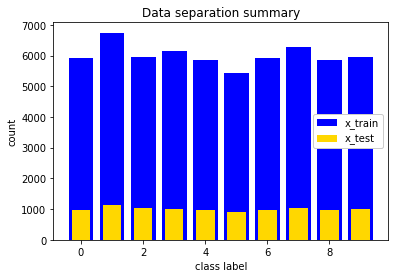

In [7]:
# summary of data shapes:
plt.figure()
plt.title('Data separation summary')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='b')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='gold', width=0.6)
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

## Build Model

In [8]:
input_shape = (target_rows, target_cols, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
______________________________________

## Graph Creation

In [9]:
# add place for input and pred label
x = Input(shape=input_shape)
y_pred = model(x)

# add place for truth label
y_true = Input(shape=(num_classes, ))

In [10]:
# define loss function in terms of y_pred and y_true
loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

# Setup metrics to look at during training:
_, acc_op = tf.metrics.accuracy(labels=tf.argmax(y_true, 1),
                                predictions=tf.argmax(y_pred,1))

## Optimizer definition - nothing different from any classical example
optimizer = tf.train.AdamOptimizer()

In [11]:
# INSPIRED by https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients

# Fetch a list of our network's trainable parameters.
trainable_vars = tf.trainable_variables()

# Create variables to store accumulated gradients
accumulators = [
    tf.Variable(
        tf.zeros_like(tv.initialized_value()),
        trainable=False
    ) for tv in trainable_vars
]

# Create a variable for counting the number of accumulations
accumulation_counter = tf.Variable(0.0, trainable=False)

# Compute gradients; grad_pairs contains (gradient, variable) pairs
grad_pairs = optimizer.compute_gradients(loss, trainable_vars)

# Create operations which add a variable's gradient to its accumulator.
accumulate_ops = [
    accumulator.assign_add(
        grad
    ) for (accumulator, (grad, var)) in zip(accumulators, grad_pairs)
]

# The final accumulation operation is to increment the counter
accumulate_ops.append(accumulation_counter.assign_add(1.0))

# Update trainable variables by applying the accumulated gradients
# divided by the counter. Note: apply_gradients takes in a list of 
# (grad, var) pairs
train_step = optimizer.apply_gradients(
    [(accumulator / accumulation_counter, var) \
        for (accumulator, (grad, var)) in zip(accumulators, grad_pairs)]
)

# Accumulators must be zeroed once the accumulated gradient is applied.
zero_ops = [
    accumulator.assign(
        tf.zeros_like(tv)
    ) for (accumulator, tv) in zip(accumulators, trainable_vars)
]

# Add one last op for zeroing the counter
zero_ops.append(accumulation_counter.assign(0.0))

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


## Split Training

In [12]:
# Initialize the session
sess = tf.Session()

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [13]:
def ceil(a,b):
    return -(-a//b)

# Loop through every class, and apply gradients after that:
for epoch in range(epochs):
    print('.'*10)
    print('Epoch %s:' % epoch)
    
    # Run the zero_ops to initialize the accumulators
    sess.run(zero_ops)
    
    # Fancy progress bar
    samples = x_train.shape[0]
    pbar = tqdm_notebook(total=samples)
    
    # Keep track of average loss/acc per class:
    accs_train = []
    losses_train = []
    
    # Iterate over every class:
    grad_feed_dict = dict()
    for idx, x_train_class in enumerate(x_train_seperated):
        
        # Get batches from class data:
        n_samples = len(x_train_class)
        better_batch_size = ceil(n_samples, ceil(n_samples, batch_size)) # helps with last batch
        
        # Accumulate the gradients in accum_vars using accum_ops
        for i in range(ceil(n_samples, better_batch_size)):
            x_batch = x_train_class[i * better_batch_size: (i+1) * better_batch_size]
            y_batch = y_train_seperated[idx][i * better_batch_size: (i+1) * better_batch_size]
            
            # get the gradients and determine accuracy/loss of model on training dataset
            _, acc_train, loss_train = sess.run([accumulate_ops, acc_op, loss], feed_dict={x: x_batch, y_true: y_batch})
            
            # increment pbar
            pbar.update(len(x_train_class[i * better_batch_size: (i+1) * better_batch_size]))
                
            # add acc and loss metrics for batch:
            accs_train.append(acc_train)
            losses_train.append(np.mean(loss_train))
            pbar.set_description('train_acc={:.2f} | train_loss={:.2f}'.format(np.mean(accs_train), np.mean(losses_train)))
        
    # Run the train_step ops to update the weights based on our accumulated gradients
    sess.run(train_step)
    acc_test, loss_test = sess.run([acc_op, loss], feed_dict={x: x_test, y_true: y_test})

    # Update progress bar
    print('Train Accuracy: {:.3f} | Loss: {:.3f}'.format(np.mean(accs_train), np.mean(losses_train)))
    print('Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test, np.mean(loss_test)))
    print()

..........
Epoch 0:


Train Accuracy: 0.067 | Loss: 2.303
Test Accuracy: 0.150 | Loss: 2.130

..........
Epoch 1:


Train Accuracy: 0.251 | Loss: 2.130
Test Accuracy: 0.281 | Loss: 1.879

..........
Epoch 2:


Train Accuracy: 0.347 | Loss: 1.881
Test Accuracy: 0.389 | Loss: 1.591

..........
Epoch 3:


Train Accuracy: 0.435 | Loss: 1.597
Test Accuracy: 0.467 | Loss: 1.293

..........
Epoch 4:


Train Accuracy: 0.500 | Loss: 1.304
Test Accuracy: 0.525 | Loss: 1.015

..........
Epoch 5:


Train Accuracy: 0.549 | Loss: 1.032
Test Accuracy: 0.570 | Loss: 0.795

..........
Epoch 6:


Train Accuracy: 0.586 | Loss: 0.816
Test Accuracy: 0.603 | Loss: 0.642

..........
Epoch 7:


Train Accuracy: 0.616 | Loss: 0.665
Test Accuracy: 0.630 | Loss: 0.544

..........
Epoch 8:


Train Accuracy: 0.641 | Loss: 0.568
Test Accuracy: 0.653 | Loss: 0.479

..........
Epoch 9:


Train Accuracy: 0.662 | Loss: 0.503
Test Accuracy: 0.672 | Loss: 0.438

..........
Epoch 10:


Train Accuracy: 0.681 | Loss: 0.461
Test Accuracy: 0.690 | Loss: 0.412

..........
Epoch 11:


Train Accuracy: 0.697 | Loss: 0.434
Test Accuracy: 0.705 | Loss: 0.397

